In [221]:
import numpy as np
import pandas as pd
import os
import pickle
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation

from keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten,Input
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.models import Model

from tensorflow.keras.optimizers import Adam, SGD 
from keras.optimizers import gradient_descent_v2 

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\maria\\Jupiter_Notebooks\\Dataset_Thermal\\SeekThermal'

In [3]:
path_train = "../SeekThermal/Train"
path_test = "../SeekThermal/Test"

### Defining the class to load images   

In [17]:
class MasterImage0(object):

    def __init__(self,PATH='', IMAGE_SIZE = 50):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE

        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []

        # This will get List of categories
        self.list_categories = []

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ",self.list_categories,'\n')
        return self.list_categories

    def process_image(self):
        try:
            """
            Return Numpy array of image
            :return: X_Data, Y_Data
            """
            self.CATEGORIES = self.get_categories()
            for categories in self.CATEGORIES:                                                  # Iterate over categories

                train_folder_path = os.path.join(self.PATH, categories)                         # Folder Path
                class_index = self.CATEGORIES.index(categories)                                 # this will get index for classification

                for img in os.listdir(train_folder_path):                                       # This will iterate in the Folder
                    new_path = os.path.join(train_folder_path, img)                             # image Path

                    try:        # if any image is corrupted
                        image_data_temp = cv2.imread(new_path)                 # Read Image as numbers
                        image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                        self.image_data.append([image_temp_resize,class_index])
                        random.shuffle(self.image_data)
                    except:
                        pass

            data = np.asanyarray(self.image_data)

            # Iterate over the Data
            for x in data:
                self.x_data.append(x[0])        # Get the X_Data
                self.y_data.append(x[1])        # get the label

            X_Data = np.asarray(self.x_data) / (255.0)      # Normalize Data
            Y_Data = np.asarray(self.y_data)
            
            # reshape x_Data

            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 3)
            print("Compiled X_data", self.X_data)
            return X_Data, Y_Data
        except:
            print("Failed to run Function Process Image ")

    def pickle_image(self):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        X_Data,Y_Data = self.process_image()

        # Write the Entire Data into a Pickle File
        pickle_out = open('X_Data','wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open('Y_Data', 'wb')
        pickle.dump(Y_Data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return X_Data,Y_Data
        print(self.X_Data)

    def load_dataset(self):

        try:
            # Read the Data from Pickle Object
            X_Temp = open('..\SeekThermal\X_Data','rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open('..\SeekThermal\Y_Data','rb')
            Y_Data = pickle.load(Y_Temp)

            print('Reading Dataset from Pickle Object')

            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            X_Data,Y_Data = self.pickle_image()
            print("X_data", self.X_Data)
            return X_Data,Y_Data
        

### Train data

In [15]:
a = MasterImage0(PATH = path_train,IMAGE_SIZE = 100)
a

In [7]:
a.get_categories()

Found Categories  ['Car', 'Cat', 'Man'] 



['Car', 'Cat', 'Man']

In [18]:
a.load_dataset()

Reading Dataset from Pickle Object


(array([[[[0.99607843, 0.98431373, 1.        ],
          [0.98823529, 0.99607843, 0.98823529],
          [1.        , 0.98823529, 0.99215686],
          ...,
          [0.6745098 , 0.16862745, 0.00392157],
          [0.67843137, 0.16470588, 0.        ],
          [0.72941176, 0.2       , 0.00392157]],
 
         [[0.94901961, 0.96470588, 0.98823529],
          [0.95686275, 0.95294118, 1.        ],
          [0.91764706, 0.96862745, 0.98823529],
          ...,
          [0.6627451 , 0.15686275, 0.00784314],
          [0.67058824, 0.15294118, 0.00392157],
          [0.70980392, 0.18039216, 0.00392157]],
 
         [[0.90196078, 0.90588235, 0.99215686],
          [0.89019608, 0.90196078, 1.        ],
          [0.90196078, 0.91372549, 0.97647059],
          ...,
          [0.65882353, 0.15686275, 0.01960784],
          [0.60784314, 0.12156863, 0.        ],
          [0.61176471, 0.12941176, 0.01176471]],
 
         ...,
 
         [[0.03529412, 0.        , 0.00392157],
          [0.06666

In [19]:
(train_images, train_labels) = a.load_dataset()

Reading Dataset from Pickle Object


In [20]:
print(train_images.shape, train_labels.shape)

(4732, 100, 100, 3) (4732,)


In [26]:
train_labels

array([0, 0, 0, ..., 2, 2, 2])

In [92]:
# 3 categories - Car, Cat and Man
np.unique(train_labels)

array([0, 1, 2])

In [93]:
### Man
train_labels_binary0 = np.where(train_labels==1, 0, train_labels) 
train_labels_binary0

array([0, 0, 0, ..., 2, 2, 2])

In [105]:
train_labels_binary = np.where(train_labels==2, 1, train_labels_binary0)

train_labels_binary 

array([0, 0, 0, ..., 1, 1, 1])

### Test data

In [32]:
class MasterImage1(object):

    def __init__(self,PATH='', IMAGE_SIZE = 50):
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE

        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []

        # This will get List of categories
        self.list_categories = []

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ",self.list_categories,'\n')
        return self.list_categories

    def process_image(self):
        try:
            """
            Return Numpy array of image
            :return: X_Data, Y_Data
            """
            self.CATEGORIES = self.get_categories()
            for categories in self.CATEGORIES:                                                  # Iterate over categories

                train_folder_path = os.path.join(self.PATH, categories)                         # Folder Path
                class_index = self.CATEGORIES.index(categories)                                 # this will get index for classification

                for img in os.listdir(train_folder_path):                                       # This will iterate in the Folder
                    new_path = os.path.join(train_folder_path, img)                             # image Path

                    try:        # if any image is corrupted
                        image_data_temp = cv2.imread(new_path)                 # Read Image as numbers
                        image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                        self.image_data.append([image_temp_resize,class_index])
                        random.shuffle(self.image_data)
                    except:
                        pass

            data = np.asanyarray(self.image_data)

            # Iterate over the Data
            for x in data:
                self.x_data.append(x[0])        # Get the X_Data
                self.y_data.append(x[1])        # get the label

            X_Data = np.asarray(self.x_data) / (255.0)      # Normalize Data
            Y_Data = np.asarray(self.y_data)

            # reshape x_Data

            X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 3)

            return X_Data, Y_Data
        except:
            print("Failed to run Function Process Image ")

    def pickle_image(self):

        """
        :return: None Creates a Pickle Object of DataSet
        """
        # Call the Function and Get the Data
        X_Data,Y_Data = self.process_image()

        # Write the Entire Data into a Pickle File
        pickle_out = open('X1_Data','wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()

        # Write the Y Label Data
        pickle_out = open('Y1_Data', 'wb')
        pickle.dump(Y_Data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return X_Data,Y_Data

    def load_dataset(self):

        try:
            # Read the Data from Pickle Object
            X_Temp = open('..\SeekThermal\X1_Data','rb')
            X_Data = pickle.load(X_Temp)

            Y_Temp = open('..\SeekThermal\Y1_Data','rb')
            Y_Data = pickle.load(Y_Temp)

            print('Reading Dataset from Pickle Object')

            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')

            X_Data,Y_Data = self.pickle_image()
            return X_Data,Y_Data

In [33]:
b = MasterImage1(PATH = path_test, IMAGE_SIZE = 100)
b

In [61]:
(test_images, test_labels) = b.load_dataset()

Reading Dataset from Pickle Object


In [83]:
test_images.shape

(1068, 100, 100, 3)

In [84]:
test_labels

array([0, 0, 0, ..., 2, 2, 2])

In [85]:
# 3 label categories

np.unique(test_labels)

array([0, 1, 2])

### Defining the Man images category as '1' vs  Car and Cat as '0'

In [86]:
### Defining Man as 1 vs the other categories
test_labels_binary0 = np.where(test_labels==1, 0, test_labels) 
test_labels_binary0

array([0, 0, 0, ..., 2, 2, 2])

In [88]:
test_labels_binary = np.where(test_labels==2, 1, test_labels_binary0)

np.unique(test_labels_binary)

array([0, 1])

##    Lets see what a random image looks like

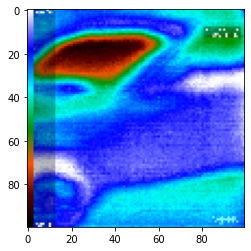

In [145]:
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
sample = random.choice(test_images)

plt.imshow(sample)

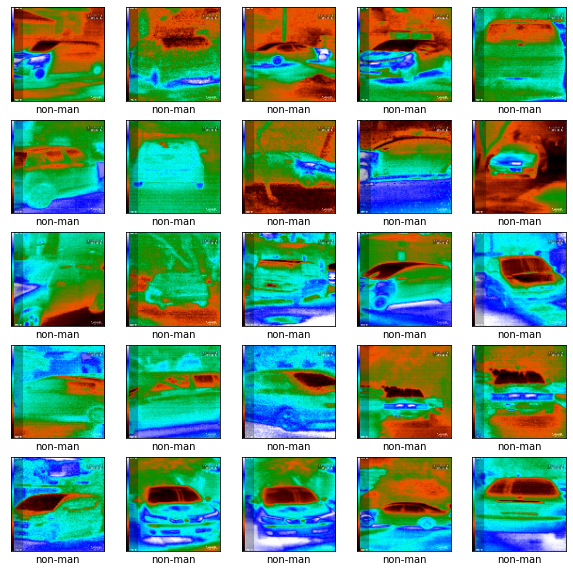

In [142]:
# First 25 images are cars
class_names = ['non-man', 'man']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[test_labels1[i][0]])
plt.show()

In [214]:
test_labels_binary = test_labels_binary.reshape(test_labels_binary.shape[0],1)
train_labels_binary = train_labels_binary.reshape(train_labels_binary.shape[0],1)

In [191]:
# Dataset shapes
print('Train: X_images=%s, y_labels=%s' % (train_images.shape, train_labels_binary.shape))
print('Test: X_images=%s, y_labels=%s' % (test_images.shape, test_labels_binary.shape))

Train: X_images=(4732, 100, 100, 3), y_labels=(4732, 1)
Test: X_images=(1068, 100, 100, 3), y_labels=(1068, 1)


In [192]:
# Setting 17% of the training set as a validation set

#validation set
X_val_images = train_images[-800:]
y_val_labels = train_labels_binary[-800:]

#training set
X_train_images = train_images[:-800]
y_train_labels = train_labels_binary[:-800]

In [193]:
print('Train: X_train_images=%s, y_train_labels=%s' % (X_train_images.shape, y_train_labels.shape))
print('Validation: X_val_images=%s, y_val_labels=%s' % (X_val_images.shape, y_val_labels.shape))

Train: X_train_images=(3932, 100, 100, 3), y_train_labels=(3932, 1)
Validation: X_val_images=(800, 100, 100, 3), y_val_labels=(800, 1)


### Building a model

In [215]:
#Import libraries and packages

import tensorflow as tf
import multiprocessing as mp

from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from keras.models import Sequential
from keras.layers.core import Dense, Activation

from keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

from keras.layers import Input
from keras.models import Model

from tensorflow.keras.optimizers import Adam, SGD
from keras.optimizers import gradient_descent_v2


### Using VGG16 pre-trained model

In [242]:
optimizer = Adam(learning_rate=0.01)

#Load VGG16 model without classifier layers
vgg = VGG16(include_top=False,weights='imagenet',input_shape=X_train_images.shape[1:])

#Add new classifier layers
layer = Flatten()(vgg.output)
layer = Dense(500,activation='relu')(layer)
layer = Dropout(0.15)(layer)
layer = Dense(250,activation='relu')(layer)
layer = Dropout(0.15)(layer)
output = Dense(1,activation='sigmoid')(layer)

#Define VGG16 model
model_VGG16 = Model(vgg.inputs,output)
model_VGG16.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model_VGG16.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0  

In [217]:
#Train VGG16 model
VGG16_trained_model = model_VGG16.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels), epochs=200)

scores = model_VGG16.evaluate(test_images, test_labels_binary, verbose=0)
print("VGG Accuracy on Test Set: %.2f%%" % (scores[1]*100))

Epoch 1/200
123/123 [==============================] - 11s 82ms/step - loss: 0.6486 - accuracy: 0.7401 - val_loss: 1.2825 - val_accuracy: 0.0000e+00
Epoch 2/200
123/123 [==============================] - 10s 79ms/step - loss: 0.4491 - accuracy: 0.7953 - val_loss: 0.8189 - val_accuracy: 0.6575
Epoch 3/200
123/123 [==============================] - 10s 79ms/step - loss: 0.2792 - accuracy: 0.8978 - val_loss: 0.6129 - val_accuracy: 0.6612
Epoch 4/200
123/123 [==============================] - 10s 80ms/step - loss: 0.1759 - accuracy: 0.9351 - val_loss: 0.5219 - val_accuracy: 0.7500
Epoch 5/200
123/123 [==============================] - 10s 80ms/step - loss: 0.1397 - accuracy: 0.9530 - val_loss: 0.3642 - val_accuracy: 0.8213
Epoch 6/200
123/123 [==============================] - 10s 80ms/step - loss: 0.1808 - accuracy: 0.9397 - val_loss: 0.6703 - val_accuracy: 0.7200
Epoch 7/200
123/123 [==============================] - 10s 81ms/step - loss: 0.1589 - accuracy: 0.9466 - val_loss: 0.6710 - va

123/123 [==============================] - 10s 83ms/step - loss: 0.0158 - accuracy: 0.9967 - val_loss: 5.9630 - val_accuracy: 0.5050
Epoch 58/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0089 - accuracy: 0.9964 - val_loss: 8.9235 - val_accuracy: 0.5475
Epoch 59/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0293 - accuracy: 0.9898 - val_loss: 1.8119 - val_accuracy: 0.7150
Epoch 60/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0124 - accuracy: 0.9967 - val_loss: 1.4818 - val_accuracy: 0.7212
Epoch 61/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 2.4789 - val_accuracy: 0.8550
Epoch 62/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0113 - accuracy: 0.9954 - val_loss: 1.2790 - val_accuracy: 0.8750
Epoch 63/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.5402 - val_accuracy

123/123 [==============================] - 10s 83ms/step - loss: 0.0012 - accuracy: 0.9992 - val_loss: 7.6808 - val_accuracy: 0.7200
Epoch 114/200
123/123 [==============================] - 10s 84ms/step - loss: 0.0011 - accuracy: 0.9995 - val_loss: 7.8771 - val_accuracy: 0.7237
Epoch 115/200
123/123 [==============================] - 10s 84ms/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 8.0182 - val_accuracy: 0.7875
Epoch 116/200
123/123 [==============================] - 10s 84ms/step - loss: 0.0016 - accuracy: 0.9992 - val_loss: 9.3336 - val_accuracy: 0.7088
Epoch 117/200
123/123 [==============================] - 10s 83ms/step - loss: 8.7883e-04 - accuracy: 0.9995 - val_loss: 25.0071 - val_accuracy: 0.6938
Epoch 118/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0040 - accuracy: 0.9992 - val_loss: 12.3142 - val_accuracy: 0.7262
Epoch 119/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 7.4764 - 

123/123 [==============================] - 10s 83ms/step - loss: 9.1111e-04 - accuracy: 0.9992 - val_loss: 5.5754 - val_accuracy: 0.8225
Epoch 169/200
123/123 [==============================] - 10s 83ms/step - loss: 6.3880e-04 - accuracy: 0.9997 - val_loss: 5.9988 - val_accuracy: 0.8175
Epoch 170/200
123/123 [==============================] - 10s 83ms/step - loss: 9.2091e-04 - accuracy: 0.9992 - val_loss: 5.2208 - val_accuracy: 0.8112
Epoch 171/200
123/123 [==============================] - 10s 83ms/step - loss: 0.0014 - accuracy: 0.9987 - val_loss: 5.9925 - val_accuracy: 0.8100
Epoch 172/200
123/123 [==============================] - 10s 84ms/step - loss: 7.9122e-04 - accuracy: 0.9995 - val_loss: 6.1268 - val_accuracy: 0.8087
Epoch 173/200
123/123 [==============================] - 10s 84ms/step - loss: 7.1644e-04 - accuracy: 0.9995 - val_loss: 6.3279 - val_accuracy: 0.8112
Epoch 174/200
123/123 [==============================] - 10s 83ms/step - loss: 8.7935e-04 - accuracy: 0.9992 - v

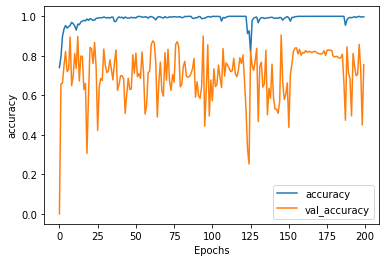

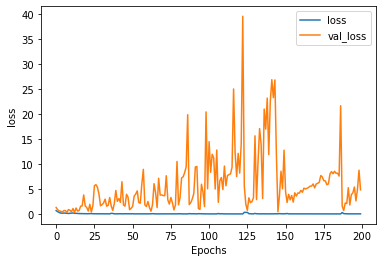

In [218]:
def plot_graphs(VGG16_trained_model, string):
    plt.plot(VGG16_trained_model.history[string])
    plt.plot(VGG16_trained_model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(VGG16_trained_model, "accuracy")
plot_graphs(VGG16_trained_model, "loss")

In [246]:
# Save the best model with early stopping and checkpoint
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
#mc = ModelCheckpoint('../SeekThermal/vgg16_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
#history = model_VGG16.fit(X_train_images, y_train_labels,  validation_data=(X_val_images, y_val_labels), epochs=200, verbose=0, callbacks=[es, mc])
# load the saved model
#saved_model = load_model('../SeekThermal/vgg16_best_model.h5')
# evaluate the model
#_, train_acc = saved_model.evaluate(X_train_images, y_train_labels, verbose=0)
#_, test_acc = saved_model.evaluate(test_images, test_labels_binary, verbose=0)
#print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

### Using the Xception pre-trained model

In [224]:
# Flipping and rotating images
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [225]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(100, 100, 3),
    include_top=False,   # Do not include the ImageNet classifier at the top.
)  

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=X_train_images.shape[1:])
x = data_augmentation(inputs)  # Apply random data augmentation

# The the rescaling layer as required by the Inception model
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The model
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.15)(x)  # Regularize with dropout
x = keras.layers.Dense(250,activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

# Define Xception model
model_xcept =  keras.Model(inputs, outputs)
model_xcept.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model_xcept.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 100, 100, 3)       0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 250)               512

In [226]:
# Train the Xception model
xception_trained_model = model_xcept.fit( X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels),verbose=2, epochs=200)

scores = model_xcept.evaluate(test_images, test_labels_binary, verbose=0)
print("Xception Accuracy on Test Set: %.2f%%" % (scores[1]*100))

Epoch 1/200
123/123 - 7s - loss: 0.5557 - accuracy: 0.7447 - val_loss: 1.4443 - val_accuracy: 0.0000e+00
Epoch 2/200
123/123 - 3s - loss: 0.5122 - accuracy: 0.7510 - val_loss: 1.2833 - val_accuracy: 0.0475
Epoch 3/200
123/123 - 3s - loss: 0.4589 - accuracy: 0.7795 - val_loss: 0.9847 - val_accuracy: 0.4300
Epoch 4/200
123/123 - 3s - loss: 0.4206 - accuracy: 0.8143 - val_loss: 0.9436 - val_accuracy: 0.5038
Epoch 5/200
123/123 - 3s - loss: 0.4004 - accuracy: 0.8235 - val_loss: 0.7803 - val_accuracy: 0.5975
Epoch 6/200
123/123 - 3s - loss: 0.3768 - accuracy: 0.8400 - val_loss: 0.7118 - val_accuracy: 0.6338
Epoch 7/200
123/123 - 3s - loss: 0.3666 - accuracy: 0.8472 - val_loss: 0.7862 - val_accuracy: 0.6075
Epoch 8/200
123/123 - 3s - loss: 0.3658 - accuracy: 0.8499 - val_loss: 0.6344 - val_accuracy: 0.6750
Epoch 9/200
123/123 - 3s - loss: 0.3480 - accuracy: 0.8586 - val_loss: 0.7138 - val_accuracy: 0.6338
Epoch 10/200
123/123 - 4s - loss: 0.3442 - accuracy: 0.8515 - val_loss: 0.6619 - val_ac

Epoch 82/200
123/123 - 3s - loss: 0.2522 - accuracy: 0.8942 - val_loss: 0.4850 - val_accuracy: 0.7950
Epoch 83/200
123/123 - 3s - loss: 0.2483 - accuracy: 0.8970 - val_loss: 0.3723 - val_accuracy: 0.8562
Epoch 84/200
123/123 - 3s - loss: 0.2545 - accuracy: 0.8932 - val_loss: 0.4951 - val_accuracy: 0.7862
Epoch 85/200
123/123 - 3s - loss: 0.2500 - accuracy: 0.8993 - val_loss: 0.3598 - val_accuracy: 0.8675
Epoch 86/200
123/123 - 3s - loss: 0.2541 - accuracy: 0.8957 - val_loss: 0.3920 - val_accuracy: 0.8450
Epoch 87/200
123/123 - 3s - loss: 0.2564 - accuracy: 0.8957 - val_loss: 0.2800 - val_accuracy: 0.8975
Epoch 88/200
123/123 - 3s - loss: 0.2644 - accuracy: 0.8922 - val_loss: 0.4774 - val_accuracy: 0.7925
Epoch 89/200
123/123 - 3s - loss: 0.2571 - accuracy: 0.8942 - val_loss: 0.4974 - val_accuracy: 0.7837
Epoch 90/200
123/123 - 3s - loss: 0.2521 - accuracy: 0.8957 - val_loss: 0.5361 - val_accuracy: 0.7663
Epoch 91/200
123/123 - 3s - loss: 0.2587 - accuracy: 0.8934 - val_loss: 0.4827 - v

Epoch 162/200
123/123 - 3s - loss: 0.2490 - accuracy: 0.8950 - val_loss: 0.7456 - val_accuracy: 0.7000
Epoch 163/200
123/123 - 3s - loss: 0.2399 - accuracy: 0.9008 - val_loss: 0.4559 - val_accuracy: 0.8175
Epoch 164/200
123/123 - 3s - loss: 0.2440 - accuracy: 0.9011 - val_loss: 0.4683 - val_accuracy: 0.8125
Epoch 165/200
123/123 - 3s - loss: 0.2384 - accuracy: 0.9056 - val_loss: 0.4497 - val_accuracy: 0.8275
Epoch 166/200
123/123 - 3s - loss: 0.2495 - accuracy: 0.8950 - val_loss: 0.3924 - val_accuracy: 0.8562
Epoch 167/200
123/123 - 3s - loss: 0.2375 - accuracy: 0.9041 - val_loss: 0.3998 - val_accuracy: 0.8562
Epoch 168/200
123/123 - 3s - loss: 0.2399 - accuracy: 0.9041 - val_loss: 0.4563 - val_accuracy: 0.8200
Epoch 169/200
123/123 - 3s - loss: 0.2291 - accuracy: 0.9087 - val_loss: 0.5065 - val_accuracy: 0.7950
Epoch 170/200
123/123 - 3s - loss: 0.2358 - accuracy: 0.9062 - val_loss: 0.5281 - val_accuracy: 0.7812
Epoch 171/200
123/123 - 3s - loss: 0.2411 - accuracy: 0.9011 - val_loss: 

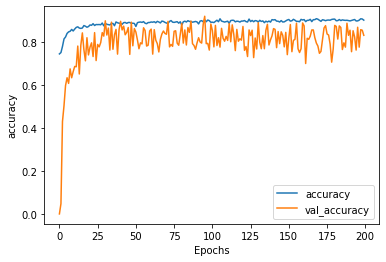

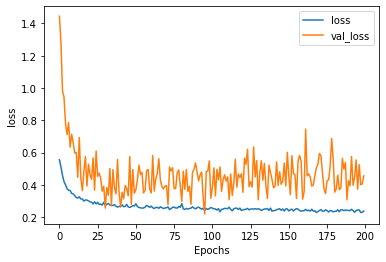

In [227]:
def plot_graphs(xception_trained_model, string):
    plt.plot(xception_trained_model.history[string])
    plt.plot(xception_trained_model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
    
  #Plot the accuracy and loss
plot_graphs(xception_trained_model, "accuracy")
plot_graphs(xception_trained_model, "loss")

In [236]:
# Save the best model with early stopping and checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('../SeekThermal/xcept_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# fit model
history = model_xcept.fit(X_train_images, y_train_labels,  validation_data=(X_val_images, y_val_labels), epochs=200, verbose=0, callbacks=[es, mc])
# load the saved model
saved_model = load_model('../SeekThermal/xcept_best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train_images, y_train_labels, verbose=0)
_, test_acc = saved_model.evaluate(test_images, test_labels_binary, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00002: val_accuracy improved from 0.00000 to 0.12125, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00003: val_accuracy improved from 0.12125 to 0.44250, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00004: val_accuracy improved from 0.44250 to 0.48500, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00005: val_accuracy improved from 0.48500 to 0.61375, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00006: val_accuracy improved from 0.61375 to 0.65250, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00007: val_accuracy did not improve from 0.65250

Epoch 00008: val_accuracy improved from 0.65250 to 0.67625, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00009: val_accuracy improved from 0.67625 to 0.74500, saving model to ../SeekThermal\xcept_best_model.h5

Epoch 00010: val_accuracy improved from 0.74500 to


Epoch 00132: val_accuracy did not improve from 0.89750

Epoch 00133: val_accuracy did not improve from 0.89750

Epoch 00134: val_accuracy did not improve from 0.89750

Epoch 00135: val_accuracy did not improve from 0.89750

Epoch 00136: val_accuracy did not improve from 0.89750

Epoch 00137: val_accuracy did not improve from 0.89750

Epoch 00138: val_accuracy did not improve from 0.89750

Epoch 00139: val_accuracy did not improve from 0.89750

Epoch 00140: val_accuracy did not improve from 0.89750

Epoch 00141: val_accuracy did not improve from 0.89750

Epoch 00142: val_accuracy did not improve from 0.89750

Epoch 00143: val_accuracy did not improve from 0.89750

Epoch 00144: val_accuracy did not improve from 0.89750

Epoch 00145: val_accuracy did not improve from 0.89750

Epoch 00146: val_accuracy did not improve from 0.89750

Epoch 00147: val_accuracy did not improve from 0.89750

Epoch 00148: val_accuracy did not improve from 0.89750

Epoch 00149: val_accuracy did not improve from 